In [3579]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------------------------------------------------------------------------
# начальные значения
v0 = 200                                # начальная скорость БЦ, м/с
theta = 30
phi = 20

geo_width = 50                          # геодезическая широта (тк нам не дано местоположение объекта)
geo_longitude = 60                      # геодезическая долгота
# -----------------------------------------------------------------------------------------------
# константы
a = 6378245                             # большая полуось Земли
b = 6356863                             # малая полуось Земли

GM = 3.986004418e14                     # произведение гравитационной постоянной Земли на массу
c_0 = 2.202095e10                       # коэффициент гравитационного поля Земли
omega = 7.292115e-5                     # угловая скорость вращения Земли
f = 298.3                               # коэффициент сжатия Земли
e_squared = (2*f-1)/((f - 1)**2)        # квадрат эксцентриситета Земли
# -----------------------------------------------------------------------------------------------
r = a/np.sqrt(1+(1/(1-1/f)**2 - 1)*(np.sin(geo_width))**2)                # расстояние от начала ГПСК до начала МЗСК
H = 5                                                                     # высота объекта над поверхностью эллипсоида

# ------------------------------------------------------------------------------------
# Формулы для пересчета из ГПСК в МЗСК
# ------------------------------------------------------------------------------------
sin_geo_width = np.sin(geo_width)                                         
cos_geo_width = np.cos(geo_width)
sin_geo_longitude = np.sin(geo_longitude)
cos_geo_longitude = np.cos(geo_longitude)

# матрица направляющих косинусов
A_mg = np.array([[-cos_geo_longitude*sin_geo_width, -sin_geo_longitude*sin_geo_width, cos_geo_width], 
                 [cos_geo_longitude*cos_geo_width, sin_geo_longitude*cos_geo_width, sin_geo_width], 
                 [-sin_geo_longitude, cos_geo_longitude, 0]])

# геоцентрическая широта начала координат МЗСК
geocentric_latitude = np.arctan((1-1/f)**2 * np.tan(geo_width))

sin_geocentric_latitude = np.sin(geocentric_latitude)
cos_geocentric_latitude = np.cos(geocentric_latitude)

# координаты центра МЗСК в ГПСК
x_0 = np.array([r*cos_geocentric_latitude*cos_geo_longitude + H*cos_geo_width*cos_geo_longitude, 
                        r*cos_geocentric_latitude*sin_geo_longitude + H*cos_geo_width*cos_geo_longitude, 
                        r*sin_geocentric_latitude + H*sin_geo_width])

In [3580]:
# -----------------------------------------------------------------------------------------------
# Функция, позволяющая получить первые и вторые производные координат
# -----------------------------------------------------------------------------------------------
def equations(coordinate, speed):
    x, y, z = coordinate
    vx, vy, vz = speed
    
    # вычисление первых производных 
    dx_dt = vx
    dy_dt = vy
    dz_dt = vz
    
    # учет ускорения свободного падения g_0
    r_0 = np.sqrt(x**2 + y**2 + z**2)
    A = GM/r_0**3
    B = (3*c_0)/r_0**2
    C = (15*c_0)/r_0**4
    D = (6*c_0)/r_0**2
    
    dvx_dt = -A*x + A*B*x - A*C*x*z**2
    dvy_dt = -A*y + A*B*y - A*C*y*z**2
    dvz_dt = -A*z + A*B*z + A*D*z - A*C*z**3
    
    # учет центростремительного ускорения БЦ
    dvx_dt += omega**2 * x
    dvy_dt += omega**2 * y
    dvz_dt += 0
    
    # учет кориолисова ускорения
    dvx_dt += 2 * omega * dy_dt
    dvy_dt += -2 * omega * dx_dt
    dvz_dt += 0
    
    # учет аэродинамического ускорения 
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # тк в задании не даны начальная масса БЦ, и другие данные, чтобы посчитать баллистический коэффициент, 
    # я приму gamma = 0,347 (нашла значения для пули)
    # для более точных расчетов нужно в процессе полета пересчитывать это значение 
    # (но тк начальных параметров нет, здесь я этого не делаю)
    gamma = 0.347 
    
    s = z/r_0                                     # синус широты цели
    h = r_0 - a/(np.sqrt(1 + e_squared * s**2))   # высота БЦ над поверхностью Земли
    rho = 10**(-1.8977 * 10**-29 * h**6 + 8.7419 * 10**-24 * h**5 - 1.4909 * 10**-18 * h**4 
               + 1.1591 * 10**(-13) * h**3 - 4.0740 * 10**(-9) * h**2 - 8.0463 * 10**(-6) * h + 2.0667 * 10**(-2))
    E = (-gamma * rho * v)/2
    
    dvx_dt += E * dx_dt
    dvy_dt += E * dy_dt
    dvz_dt += E * dz_dt
    
    return np.array([dx_dt, dy_dt, dz_dt, dvx_dt, dvy_dt, dvz_dt])


In [3581]:
# -------------------------------------------------------------------------------------
# Метод Рунге-Кутты 4 порядка
# 
# Шаг в методе Рунге-Кутты -- dt. Шаг выбирается так, чтобы обеспечить достаточную 
# точность вычислений отностительно времени вычисления (t_end).
# 
# -------------------------------------------------------------------------------------
def runge_kutta_4(t0, t_end, dt, initial_coordinate, initial_speed):
    # h = t_end/dt
    t = t0
    coordinates = [initial_coordinate]
    speeds = [initial_speed]
    
    while t < t_end:
        coordinate = coordinates[-1]
        speed = speeds[-1]
        
        
        k1 = equations(coordinate, speed)
        q1 = speed
        k2 = equations(coordinate + dt/2 * q1, speed + dt/2 * k1[-3:])
        q2 = q1 + k1[-3:] * dt/2
        k3 = equations(coordinate + dt/2 * q2, speed + dt/2 * k2[-3:])
        q3 = q1 + k2[-3:] * dt/2
        k4 = equations(coordinate + dt * q3, speed + dt * k3[-3:])
        q4 = q1 + k3[-3:] * dt                             
        
        new_coordinate = coordinate + dt/6 * (q1 + 2*q2 + 2*q3 + q4)
        coordinates.append(new_coordinate)
        
        new_speed = speed + dt/6 * (k1[-3:] + 2*k2[-3:] + 2*k3[-3:] + k4[-3:])
        speeds.append(new_speed)

        t += dt #h
        
    return [np.array(coordinates), np.array(speeds)]


In [3582]:
# -------------------------------------------------------------------------------------
t0 = 0                      # начальный момент времени
t_end = 10000               # конечный момент времени
dt = 10                     # шаг для метода рунге кутты
# -------------------------------------------------------------------------------------
# Основная функция для получения координат и их первых производных
# -------------------------------------------------------------------------------------
def get_result():

    
    initial_coordinate = np.array([x_0[0], x_0[1], x_0[2]])
    initial_speed = np.array([v0 * np.sin(theta) * np.cos(phi), 
                              v0 * np.sin(theta) * np.sin(phi), 
                              v0 * np.cos(theta)])

    result = runge_kutta_4(t0, t_end, dt, initial_coordinate, initial_speed)
    
    coordinate = result[0]
    speed = result[1]

    # извлечение координат и времени из результата
    x = coordinate[:, 0]
    y = coordinate[:, 1]
    z = coordinate[:, 2]
    vx = speed[:, 0]
    vy = speed[:, 1]
    vz = speed[:, 2]
    t = np.arange(t0, t_end + dt, dt)
    t_list = t.tolist()
    
    return [x, y, z, vx, vy, vz, t_list] 
# print(get_result()[0])
# print(get_result()[1])
# print(get_result()[2])

In [3583]:
# -------------------------------------------------------------------------------------
# Перевод координат из ГПСК в МЗСК
# -------------------------------------------------------------------------------------
def recalculation_GPSK_MZSK(result):       
    iterations = len(result[0])
    print(len)
    
    x = []
    y = []
    z = []
    vx = []
    vy = []
    vz = []
    xyz = []
    vx_vy_vz = []
    
    # Формирование списка координат и списка скоростей, переведенных в МЗСК
    for i in range(iterations):
        
        coordinates_g = np.array([result[0][i], result[1][i], result[2][i]])
        coordinates_m = np.dot(A_mg, coordinates_g - x_0) 
        
        xyz.append(coordinates_m.tolist())
        x.append(xyz[i][0])
        y.append(xyz[i][1])
        z.append(xyz[i][2])     
        
        speeds_g = np.array([result[3][i], result[4][i], result[5][i]])
        speeds_m = np.dot(A_mg, speeds_g)
        
        if(i == 0):
            vx_vy_vz.append(speeds_g.tolist())
        else:
            vx_vy_vz.append(speeds_m.tolist())
        
        vx.append(vx_vy_vz[i][0])
        vy.append(vx_vy_vz[i][1])
        vz.append(vx_vy_vz[i][2])
        
        i += 1 
            
    return np.array([x, y, z, vx, vy, vz])

# recalculation_GPSK_MZSK(get_result())[3:6]


In [3584]:
# -------------------------------------------------------------------------------------
# Выделение из ответа координат и скоростей для последующих расчетов
# -------------------------------------------------------------------------------------
result = recalculation_GPSK_MZSK(get_result())
x = result[0]
y = result[1]
z = result[2]

vx = result[3]
vy = result[4]
vz = result[5]

t = get_result()[6]
# -------------------------------------------------------------------------------------
# Вычисление скорости и дальности в МЗСК 
# -------------------------------------------------------------------------------------
v = np.sqrt(vx**2 + vy**2 + vz**2) 
L = np.sqrt(x**2 + y**2)    
# -------------------------------------------------------------------------------------
# Составление таблицы с основными данными
# -------------------------------------------------------------------------------------
result_data = pd.DataFrame()

result_data['t'] = list(map(int, t[0 : 10000 : 100]))
result_data['x'] = list(map(int, x[0 : 10000 : 100]))
result_data['y'] = list(map(int, y[0 : 10000 : 100]))
result_data['z'] = list(map(int, z[0 : 10000 : 100]))
result_data['L'] = list(map(int, L[0 : 10000 : 100]))

result_data

# -------------------------------------------------------------------------------------
# Все расчеты проводятся в системе ГПСК(Гринвичская прямоугольная система координат). Начало ГПСК находится в центре Земли.
# Далее полученные координаты и скорости переводятся в МЗСК - местная земная система координат
# -------------------------------------------------------------------------------------

<built-in function len>


,t,x,y,z,L
0,0,0,0,0,0
1,1000,261688406667,504636127080,535721630230,568452674317
2,2000,544447708271,1084466531854,990117757312,1213462387449
3,3000,844522713309,1727980880940,1352384220400,1923313946861
4,4000,1159226694765,2425297890897,1615557575793,2688099028951
5,5000,1485703413552,3165912844340,1773689561125,3497187265646
6,6000,1820951881469,3938788663488,1821902892211,4339345790582
7,7000,2161852330282,4732451419654,1756438642583,5202855171666
8,8000,2505193195677,5535089575191,1574694839862,6075624210981
9,9000,2847698917347,6334656227068,1275255974852,6945304790935


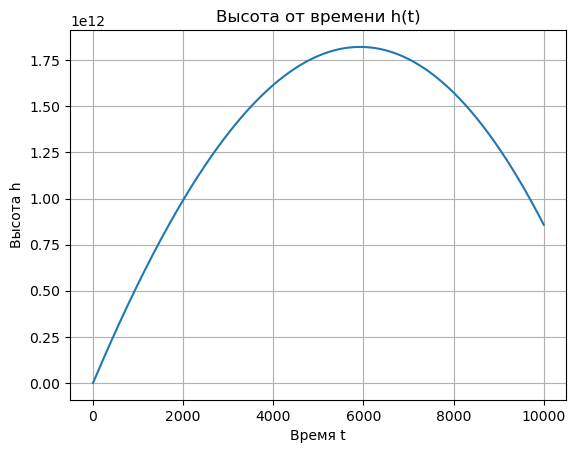

In [3585]:
# -------------------------------------------------------------------------------------
# Визуализация высоты от времени
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(t, z)
plt.xlabel('Время t')
plt.ylabel('Высота h')
plt.title('Высота от времени h(t)')
plt.grid(True)

plt.show()


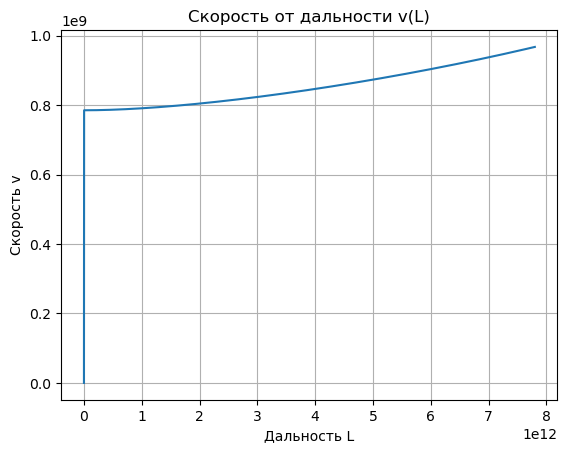

,t,vx,vy,vz,v,L
0,0,-80,-180,30,200,0
1,1000,273252977,544867908,497898518,787052198,568452674317
2,2000,291849621,613262915,409573406,793106537,1213462387449
3,3000,307852210,672117468,313797881,803108949,1923313946861
4,4000,321079299,720764245,211556521,816914424,2688099028951
5,5000,331373540,758624554,103893777,834334198,3497187265646
6,6000,338602983,785213106,-8094247,855147426,4339345790582
7,7000,342662189,800142110,-123268406,879113117,5202855171666
8,8000,343473140,803124640,-240455454,905981132,6075624210981
9,9000,340985964,793977266,-358457264,935501436,6945304790935


In [3586]:
# -------------------------------------------------------------------------------------
# Визуализация скорости от дальности
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(L, v)
plt.xlabel('Дальность L')
plt.ylabel('Скорость v')
plt.title('Скорость от дальности v(L)')
plt.grid(True)

plt.show()

# -------------------------------------------------------------------------------------
# Таблица скорости от дальности
# -------------------------------------------------------------------------------------
data = pd.DataFrame()
data['t'] = t[0 : 10000 : 100]
data['vx'] = list(map(int, vx[0 : 10000 : 100]))
data['vy'] = list(map(int, vy[0 : 10000 : 100]))
data['vz'] = list(map(int, vz[0 : 10000 : 100]))
data['v'] = list(map(int, v[0 : 10000 : 100]))
data['L'] = list(map(int, L[0 : 10000 : 100]))
data

In [3587]:
# -------------------------------------------------------------------------------------
# Нахождение ускорения
# -------------------------------------------------------------------------------------


# -------------------------------------------------------------------------------------
# Визуализация ускорения от времени
# -------------------------------------------------------------------------------------
# plt.figure()
# plt.plot(t, a)
# plt.xlabel('Время')
# plt.ylabel('Ускорение')
# plt.title('Ускорение от времени')
# plt.grid(True)

plt.show()

In [3588]:
# -------------------------------------------------------------------------------------
# Визуализация ускорения от дальности
# -------------------------------------------------------------------------------------
# plt.figure()
# plt.plot(x, a)
# plt.xlabel('Дальность')
# plt.ylabel('Ускорение')
# plt.title('Ускорение от дальности')
# plt.grid(True)

plt.show()

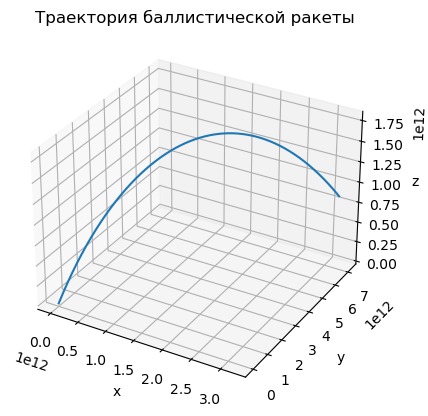

In [3589]:
# -------------------------------------------------------------------------------------
# Визуализация траектории ракеты в 3D
# -------------------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Траектория баллистической ракеты')

plt.show()